In [192]:
import torch
import torch.nn.functional as F
from torch import nn
import pandas as pd
import matplotlib.pyplot as plt
from latex import latexify, format_axes
from pprint import pprint
from sklearn.manifold import TSNE
import torch._dynamo
torch._dynamo.config.suppress_errors = True
%matplotlib inline
%config InlineBackend.figure_format = "retina"

In [24]:
!sudo apt install cm-super dvipng texlive-latex-extra texlive-latex-recommended

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
cm-super is already the newest version (0.3.4-17).
dvipng is already the newest version (1.15-1.1).
texlive-latex-extra is already the newest version (2021.20220204-1).
texlive-latex-recommended is already the newest version (2021.20220204-1).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.


In [25]:
if (torch.cuda.is_available()):
    device = torch.device("cuda")
elif (torch.backends.mps.is_available()):
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print(device)

cuda


## **Tolstoy Corpus**

In [26]:
fileTolstoy = open("tolstoy.txt", "r")
tolstoy = fileTolstoy.read()
print(tolstoy[:1000])
new_tolstoy = ""
for char in tolstoy:
    if char in ['à', 'ä', 'é', 'ê']:
        continue
    new_tolstoy += char

characters = sorted(list(set(new_tolstoy)))
print(len(new_tolstoy))
print(len(characters))
print(characters)

"Well, Prince, so Genoa and Lucca are now just family estates of the
Buonapartes. But I warn you, if you don't tell me that this means war,
if you still try to defend the infamies and horrors perpetrated by that
Antichrist--I really believe he is Antichrist--I will have nothing more
to do with you and you are no longer my friend, no longer my 'faithful
slave,' as you call yourself! But how do you do? I see I have frightened
you--sit down and tell me all the news."

It was in July, 1805, and the speaker was the well-known Anna Pavlovna
Scherer, maid of honor and favorite of the Empress Marya Fedorovna. With
these words she greeted Prince Vasili Kuragin, a man of high rank and
importance, who was the first to arrive at her reception. Anna Pavlovna
had had a cough for some days. She was, as she said, suffering from la
grippe; grippe being then a new word in St. Petersburg, used only by the
elite.

All her invitations without exception, written in French, and delivered
by a scarlet-liverie

In [28]:
stoi = {s : i + 1 for i, s in enumerate(characters)}
stoi["_"] = 0
itos = {i : s for s, i in stoi.items()}
pprint(itos)

{0: '_',
 1: '\n',
 2: ' ',
 3: '!',
 4: '"',
 5: "'",
 6: '(',
 7: ')',
 8: '*',
 9: ',',
 10: '-',
 11: '.',
 12: '/',
 13: '0',
 14: '1',
 15: '2',
 16: '3',
 17: '4',
 18: '5',
 19: '6',
 20: '7',
 21: '8',
 22: '9',
 23: ':',
 24: ';',
 25: '=',
 26: '?',
 27: 'A',
 28: 'B',
 29: 'C',
 30: 'D',
 31: 'E',
 32: 'F',
 33: 'G',
 34: 'H',
 35: 'I',
 36: 'J',
 37: 'K',
 38: 'L',
 39: 'M',
 40: 'N',
 41: 'O',
 42: 'P',
 43: 'Q',
 44: 'R',
 45: 'S',
 46: 'T',
 47: 'U',
 48: 'V',
 49: 'W',
 50: 'X',
 51: 'Y',
 52: 'Z',
 53: 'a',
 54: 'b',
 55: 'c',
 56: 'd',
 57: 'e',
 58: 'f',
 59: 'g',
 60: 'h',
 61: 'i',
 62: 'j',
 63: 'k',
 64: 'l',
 65: 'm',
 66: 'n',
 67: 'o',
 68: 'p',
 69: 'q',
 70: 'r',
 71: 's',
 72: 't',
 73: 'u',
 74: 'v',
 75: 'w',
 76: 'x',
 77: 'y',
 78: 'z'}


![](./MLPToken.svg)

## Generating the Training Samples

In [29]:
block_size = 10
start = 0
X, Y = [], []
context = [0] * block_size
for idx in range(len(new_tolstoy)):
  ix = stoi[new_tolstoy[idx]]
  X.append(context)
  Y.append(ix)
  # print(''.join(itos[i] for i in context), '--->', itos[ix])
  context = context[1:] + [ix]

X = torch.tensor(X).to(device)
Y = torch.tensor(Y).to(device)

In [30]:
X.shape, Y.shape

(torch.Size([3196195, 10]), torch.Size([3196195]))

In [31]:
# Embedding layer for the context
emb_dim = 10
emb = torch.nn.Embedding(len(stoi), emb_dim)

In [32]:
emb.weight

Parameter containing:
tensor([[ 1.7841e+00,  4.2184e-01, -1.4891e+00,  1.2501e+00,  1.8239e-02,
          1.2394e+00,  5.5083e-01,  2.8159e+00,  9.9539e-01,  2.6041e+00],
        [-1.1486e+00, -1.3569e+00, -5.6997e-01, -4.8871e-01, -5.2794e-01,
          3.2839e-01, -1.8197e+00,  1.9827e+00, -1.8484e-01, -8.9803e-01],
        [ 1.2774e-01,  3.0849e-01,  7.5379e-01,  2.1227e+00, -4.4474e-01,
         -1.2324e+00, -2.6366e+00, -1.3643e-01,  2.8425e-01, -6.8222e-01],
        [ 1.0031e+00,  8.9938e-02, -1.0317e+00,  3.5074e-01, -1.1394e+00,
         -1.2864e+00, -1.1493e+00,  6.1294e-01,  1.3149e-01, -3.7797e-01],
        [-1.0396e+00,  3.9536e-01, -2.0006e+00,  4.8002e-01, -5.4949e-01,
          4.0832e-01,  1.1016e+00,  1.3341e+00, -3.9839e-01, -9.7616e-01],
        [ 8.2786e-01, -1.2420e+00, -8.6082e-02,  7.4290e-01, -7.6109e-02,
          1.7301e+00,  4.2414e-01, -1.0836e+00, -1.4192e-01,  3.6837e-01],
        [-5.1295e-01,  1.2662e-01, -8.3615e-01, -6.5670e-01, -8.8998e-02,
          

In [33]:
emb.weight.shape

torch.Size([79, 10])

## Function to visualize the embedding in 2d space using **t-SNE**

<Axes: >

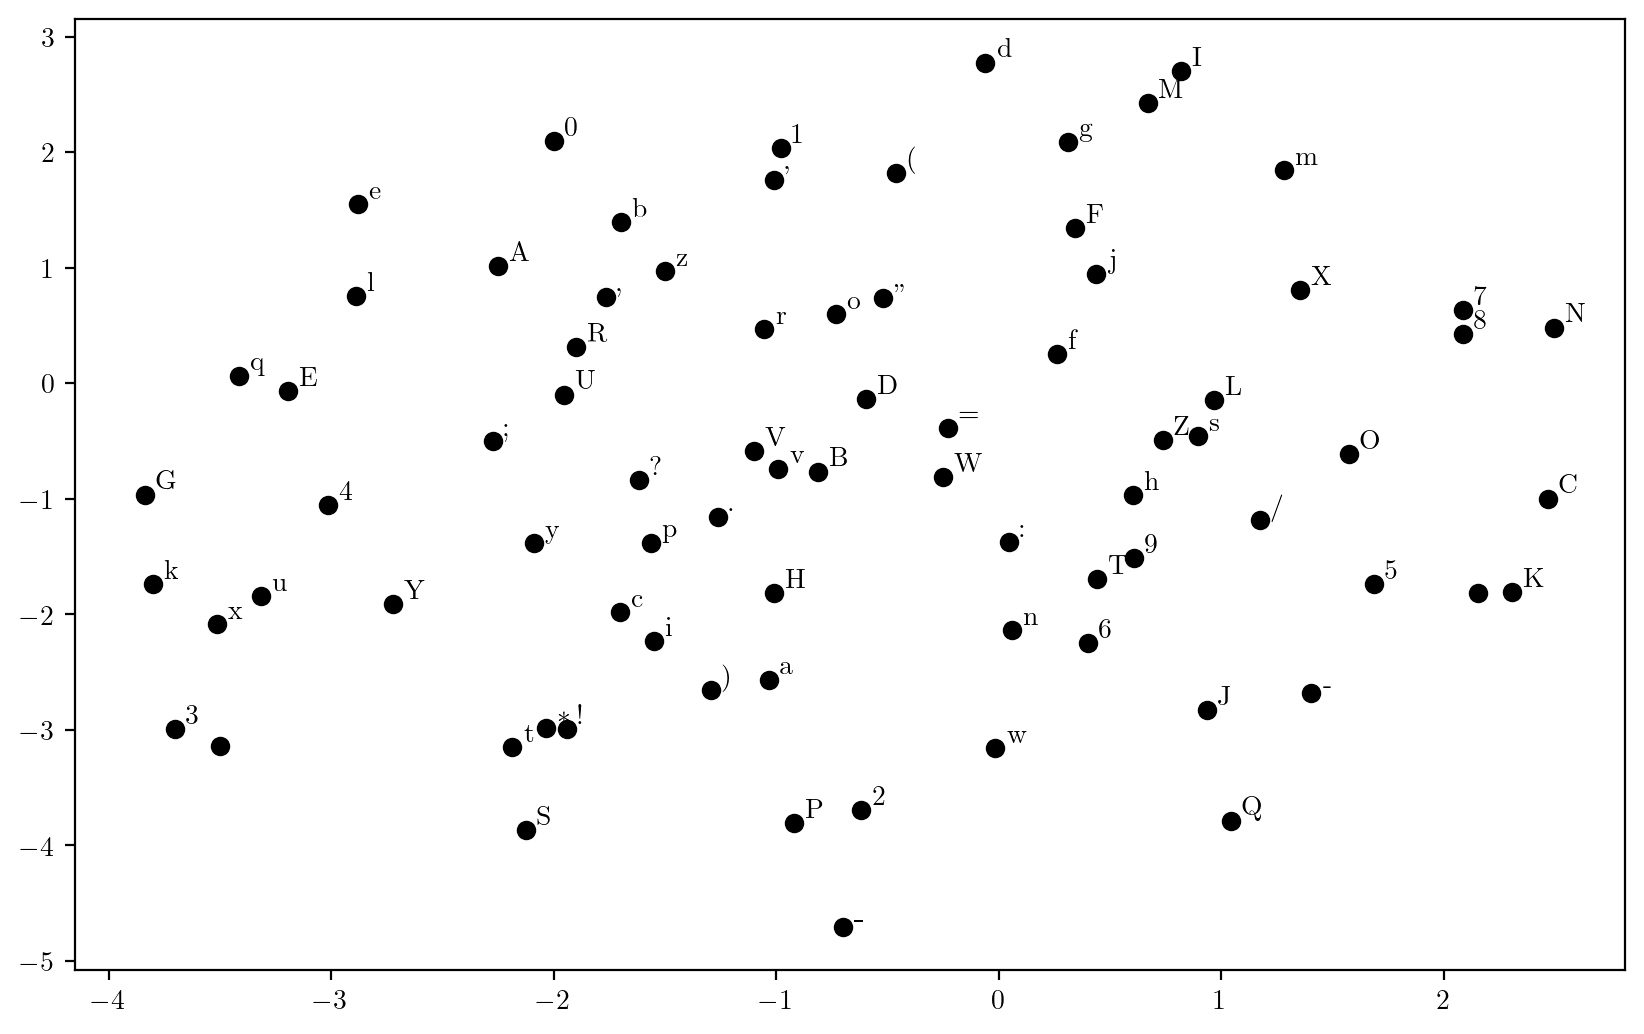

In [34]:
latexify(columns = 2, fig_width = 10)
def plot_emb(emb, itos, ax=None):
    if emb.weight.shape[1] != 2:
      tsne = TSNE(n_components = 2)
      emb_new = tsne.fit_transform(emb.weight.detach().cpu().numpy())
    if ax is None:
        fig, ax = plt.subplots()
    for i in range(len(itos)):
        if emb.weight.shape[1] == 2:
          x, y = emb.weight[i].detach().cpu().numpy()
          ax.scatter(x, y, color='k')
          ax.text(x + 0.05, y + 0.05, itos[i])
        else:
          x, y = emb_new[i]
          ax.scatter(x, y, color = 'k')
          ax.text(x + 0.05, y + 0.05, itos[i])
    return ax

plot_emb(emb, itos)

## Structure of the **MLP**

![Alt](./Embed.svg)
![Alt](./ModelEmbed.svg)

In [36]:
class NextChar(nn.Module):
  def __init__(self, block_size, vocab_size, emb_dim, hidden_size):
    super().__init__()
    self.emb = nn.Embedding(vocab_size, emb_dim)
    self.lin1 = nn.Linear(block_size * emb_dim, hidden_size)
    self.lin2 = nn.Linear(hidden_size, vocab_size)

  def forward(self, x):
    x = self.emb(x)
    x = x.view(x.shape[0], -1)
    x = torch.sin(self.lin1(x))
    x = self.lin2(x)
    return x

In [37]:
model = NextChar(block_size, len(stoi), emb_dim, 10).to(device)
model = torch.compile(model)

In [38]:
for param_name, param in model.named_parameters():
    print(param_name, param.shape)

_orig_mod.emb.weight torch.Size([79, 10])
_orig_mod.lin1.weight torch.Size([10, 100])
_orig_mod.lin1.bias torch.Size([10])
_orig_mod.lin2.weight torch.Size([79, 10])
_orig_mod.lin2.bias torch.Size([79])


## Generating names from untrained model

In [40]:
import warnings
warnings.filterwarnings("ignore")

g = torch.Generator()
g.manual_seed(42)
def generate_name(model, itos, block_size, max_len):
    context = [0] * block_size
    text = ''
    for i in range(max_len):
        x = torch.tensor(context).view(1, -1).to(device)
        y_pred = model(x)
        ix = torch.distributions.categorical.Categorical(logits = y_pred).sample().item()
        ch = itos[ix]
        text += ch
        context = context[1:] + [ix]
    return text

print(generate_name(model, itos, block_size, 1000))

niA*
JEXz_BzvC?IqrNJF=VUW"sshi=bc  XmZweUbfIPT7Fr-5.a)/cH!:EBF1q)/FLj--s:/U*m)?HGT5,SWkx/j1U82dKu2ct4IfB1LbLs
mwBs*c"ZA''3o'3GTn=JCmrYNrAOFSIpIW"R=QmHdQ;?GknoqPV.G9VFe8/UOM40jq?RywzJa:2f0MJqRRF'XYHVce.QnM9Whs,8Du QpZh,cR5CJ8!4JOQ0i1JZ-c
V!X*=dvaq6GNQpd
G,-5_48,NQh7n11JgChhfnmDoOgZAtu8LvvczZK!4W?8"YUrQ7*-y'f"WQtMP=1InIdh!01,L1jL:e/p?n25ZbIWl:=_H=apti5cq;5N2eTopAJ.c"U06M? v:FiRZf*wx'_F.1M,4
3PGi/F(uwlnA1 .k8eC faliUj0dm5zOIFDiWxPcyokYDz57nHzC(pE):9euKZDp H_tjAET6TgsLXirJsLD3V55=IlfMSC;ZWP!OH?-
PiZe D(c9Rx:vGFp
cE7Sfwn=RWt'Bc1Q:u"0hSCcnD.j0uUeDsm81V1EP c".ZH*Z:GA1vmvRkc
Us7-rZUJ!M.P(_s0aQ
:XeeIPH.7aJx/WzXFF5Vh.gLrlbAei *?1=sOLQ=HF2.2M8/GTVSG!Q b:"!5'vWM! wwM6!tUu
cQ!HI)QHoo1f?nu/IrrqtX7N3RLmDheSdHZ5
n yxr7Zfpc)k=Id2bhbDpcqyUXrszJVKkS.w-f'41Vvo2"L7q(CsGB9-jvrbkME5*_d
p5.9.aB8g(70SI5i50 Z7TB3
jYbCk 2.mPAHsN-61dimXaY0:WUxD=4,6YL_jJvH0i!p?XK'FmYvAA;*UsAR-HgZK967cM "K *veRAPZkNeIll0F6.)Z hR)=npNqMa;v(oAE;eQC":-ElPEMz 2
VyC"pf.'KNWXNO6eeC:?H7oye_O;eR4Fs_!k'=F9::d"'r)C !E3)i_CT1:,K.G,5mR3,Wa'5Ke

## Model Training

In [41]:
loss_fn = nn.CrossEntropyLoss()
opt = torch.optim.AdamW(model.parameters(), lr=0.01)
import time
# Mini-batch training
batch_size = 4096
print_every = 100
elapsed_time = []
for epoch in range(10000):
    start_time = time.time()
    for i in range(0, X.shape[0], batch_size):
        x = X[i:i+batch_size]
        y = Y[i:i+batch_size]
        y_pred = model(x)
        loss = loss_fn(y_pred, y)
        loss.backward()
        opt.step()
        opt.zero_grad()
    end_time = time.time()
    elapsed_time.append(end_time - start_time)
    if epoch % print_every == 0:
        print(epoch, loss.item())

0 2.2033867835998535
100 2.154784679412842
200 2.1512084007263184
300 2.1563048362731934
400 2.154481887817383
500 2.141117811203003
600 2.140599489212036


KeyboardInterrupt: 

In [42]:
torch.save(model.state_dict(), "model.pth")

In [195]:
model = NextChar(block_size, len(stoi), emb_dim, 10)
model.load_state_dict(torch.load("model.pth", map_location = torch.device("cpu")))
model.eval()

RuntimeError: Error(s) in loading state_dict for NextChar:
	Missing key(s) in state_dict: "emb.weight", "lin1.weight", "lin1.bias", "lin2.weight", "lin2.bias". 
	Unexpected key(s) in state_dict: "_orig_mod.emb.weight", "_orig_mod.lin1.weight", "_orig_mod.lin1.bias", "_orig_mod.lin2.weight", "_orig_mod.lin2.bias". 

## Visualize the Learnt Embedding

<Axes: >

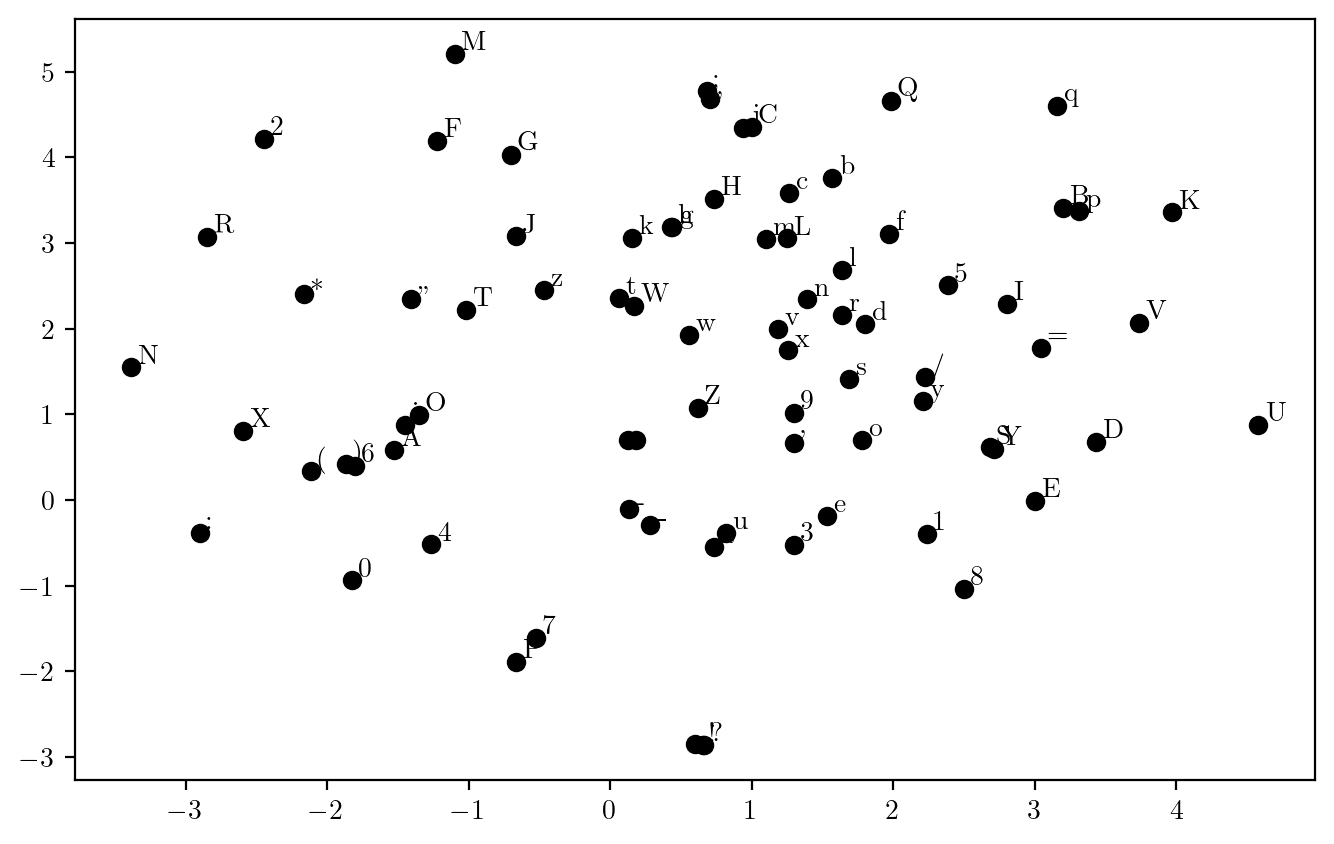

In [43]:
latexify(columns = 2, fig_width = 8)
plot_emb(model.emb, itos)

## Generating Names from the Model

In [47]:
print(generate_name(model, itos, block_size, 1000))

p r  , eoe m
the feem the find somust add seick prot'. I dide to
and the
tory hooatly aran
py ker now risced thererofnes
esuctenta he lreraioly bist ont. "Hio come usted angare Nadapare wher the setscilles. sevatioce cuing surd anderung to and the doking hakionds ighag a noon
ther ounting tancharsmers, quer hirled mar ther to
sat stont witttted
for megereru. Thach owt Rh to gnlad awoth nerd res I am ther, wing whekor a corridd eave beplemirked mequs elisomy somsd an wencad hein od, hen
the dou, haw Bras t hok ind exflev's and bam sivoraed da and
to yeat coge opareris fore wching of thisg, brimanns doffot?
Sitt, Shed and ganesthiv gusis eit it tire.

Fendown, who ive.
I santur esseled bend in; puper andzon
an lount theasih tlobly he a awfninghe buctececiov in heiting haly one weyesining, Sof come iwo rive had Any, a cadnt denod haled sent arodlin notouw pid had rall motariders coquatking, at
gchick yroppet founce; a hen faneds a thezo then Nachoughhn. "You unokis wheed heesuplied. At ro